In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(784, 128)
        self.encoder_output_layer = nn.Linear(128, 128)

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = F.relu(activation)
        code = self.encoder_output_layer(activation)
        code = F.relu(code)
        return code


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_hidden_layer = nn.Linear(128, 128)
        self.decoder_output_layer = nn.Linear(128, 784)

    def forward(self, features):
        activation = self.decoder_hidden_layer(features)
        activation = F.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = F.relu(activation)
        return reconstructed


class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, features):
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed


In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [5]:
train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)


3.3%

100.0%


Extracting /Users/dodkins/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /Users/dodkins/torch_datasets/MNIST/raw



100.0%

Extracting /Users/dodkins/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/dodkins/torch_datasets/MNIST/raw




100.0%
100.0%


Extracting /Users/dodkins/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/dodkins/torch_datasets/MNIST/raw

Extracting /Users/dodkins/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/dodkins/torch_datasets/MNIST/raw



In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [7]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 0.034081
epoch : 2/20, loss = 0.019451
epoch : 3/20, loss = 0.017439
epoch : 4/20, loss = 0.016314
epoch : 5/20, loss = 0.015637
epoch : 6/20, loss = 0.015214
epoch : 7/20, loss = 0.014857
epoch : 8/20, loss = 0.014589
epoch : 9/20, loss = 0.014376
epoch : 10/20, loss = 0.014192
epoch : 11/20, loss = 0.014040
epoch : 12/20, loss = 0.013912
epoch : 13/20, loss = 0.013796
epoch : 14/20, loss = 0.013689
epoch : 15/20, loss = 0.013592
epoch : 16/20, loss = 0.013517
epoch : 17/20, loss = 0.013448
epoch : 18/20, loss = 0.013384
epoch : 19/20, loss = 0.013322
epoch : 20/20, loss = 0.013263


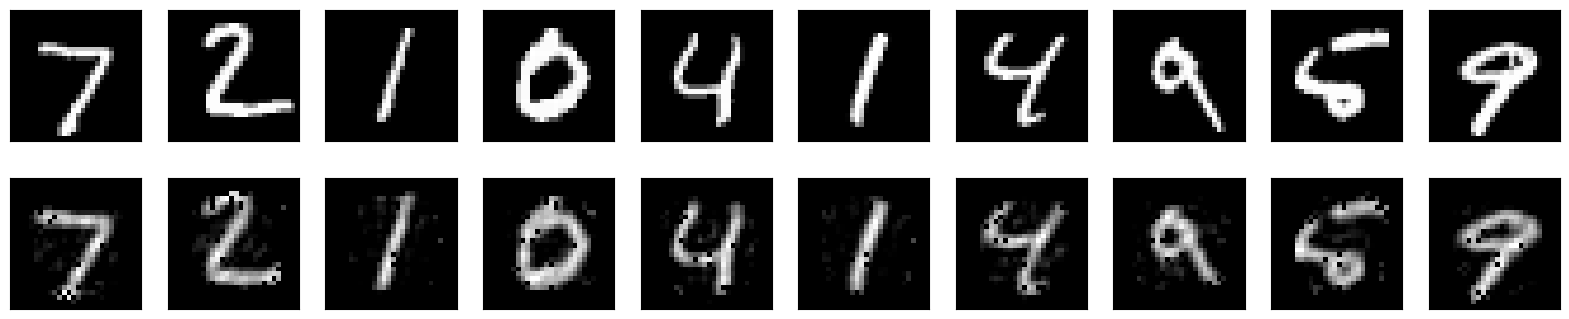

In [8]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_dataset.data[index].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        test_data = test_dataset.data[index]
        test_data = test_data.to(device)
        test_data = test_data.float()
        test_data = test_data.view(-1, 784)
        output = model(test_data)
        plt.imshow(output.cpu().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()